# Image processing coursework 1

## Loading in images and dependencies

(2814, 2110, 3)
(2814, 2110, 3)


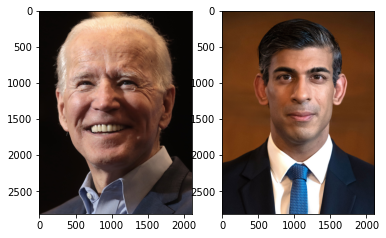

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.spatial import Delaunay
import dlib, cv2
import os

image1 = plt.imread('Images\Joe_Biden.jpg')
image2 = plt.imread('Images\Sunak.jpg')
image2 = np.copy(image2[0:2814, 100:2210,:])
print(image1.shape)
print(image2.shape)
plt.subplot(1, 2, 1)
plt.imshow(image1)
plt.subplot(1, 2, 2)
plt.imshow(image2)


Get the landmark detector

In [2]:
dat_path = 'shape_predictor_68_face_landmarks.dat'
file_path = 'shape_predictor_68_face_landmarks.dat.bz2'
url = 'http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2'
 
if not os.path.exists(dat_path):
    os.system('wget {} -O {}'.format(url, file_path))
    os.system('bunzip2 {} '.format(file_path))

## Detecting facial landmarks

In [3]:
def shape_to_np(shape, dtype="int"):
    '''
    convert the dlib shape to numpy ndarray
    '''
    coords = np.zeros((68, 2), dtype=dtype)
    for i in range(68):
        coords[i,0] = shape.part(i).x
        coords[i,1] = shape.part(i).y
    return coords

def landmark_detector(img):
    '''
    Outputs ndarray of landmarks for img
    '''
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')
    rects = detector(img, 1)
    rect = rects[0]
    shape = predictor(img, rect)
    shape = shape_to_np(shape)
    return shape

def add_edge_marks(img, landmarks, size=(6, 7)):
    '''
    NOTE: size should be (W, H)
    Add the edge landmarks to the img
    '''
    H, W, _ = img.shape
    H -= 1
    W -= 1
    # side made of (constant axis value, moving axis lim, moving axis)
    # reverse 0 and 1 as plt scatter is x, y (W, H)
    sides = [(0, W, 0), (H, W, 0), (0, H, 1), (W, H, 1)]
    for (ca, mal, ma) in sides:
        ma_range = np.linspace(0, mal, size[ma], dtype=int)
        edge = np.full((size[ma], 2),ca,dtype=int)
        edge[:,ma] = ma_range
        landmarks = np.vstack((landmarks, edge))
    return landmarks

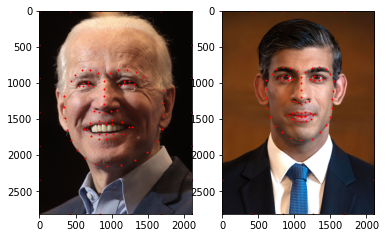

In [4]:
landmark = landmark_detector(image1)
landmark1 = add_edge_marks(image1, landmark)
landmark = landmark_detector(image2)
landmark2 = add_edge_marks(image2, landmark)
plt.subplot(1, 2, 1)
plt.scatter(landmark1[:, 0], landmark1[:,1], s=1, color='red')
plt.imshow(image1)
plt.subplot(1, 2, 2)
plt.scatter(landmark2[:, 0], landmark2[:,1], s=1, color='red')
plt.imshow(image2)

## Constructing triangles

Functions for determining points in triangle

In [20]:
def barycentric(p, p1, p2):
    '''
    Support an array of points 2D
    '''
    return np.sign((p[:,0] - p2[0]) * (p1[1] - p2[1]) - (p1[0] - p2[0]) * (p[:,1] - p2[1]))

def in_triangle(points, tri_coord):
    '''
    Support an array of points
    '''
    # d1, d2, d3 = all the points' area sign with edge 1, 2, 3 
    d1 = barycentric(points, tri_coord[0], tri_coord[1])
    d2 = barycentric(points, tri_coord[1], tri_coord[2])
    d3 = barycentric(points, tri_coord[2], tri_coord[0])

    return np.where((d1==d2)&(d2==d3))


def segmented_image(img, tri_coords):
    H, W, _ = img.shape
    output = np.zeros((W, H))
    output = output.flatten()
    x, y = np.mgrid[0:W, 0:H]
    all_positions = np.append(x.reshape(-1,1),y.reshape(-1,1),axis=1)
    n_tri = tri_coords.shape[0]
    for k in range(n_tri):
        points_in_k = in_triangle(all_positions, tri_coords[k])
        output[points_in_k] = k#int(k%2)*int(n_tri/2) + k
    output = output.reshape((W, H)).T
    return output

In [6]:
tri1 = Delaunay(landmark1)
tri2 = Delaunay(landmark2)

simplices1 = tri1.simplices
points1_tri = landmark1[tri1.simplices]
simplices2 = tri2.simplices
points2_tri = landmark2[tri2.simplices]

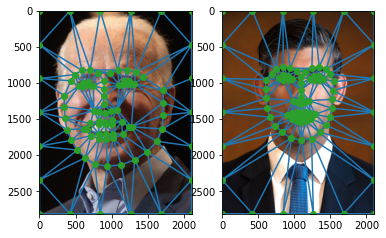

In [7]:
plt.subplot(1, 2, 1)
plt.triplot(landmark1[:,0], landmark1[:,1], simplices1)
plt.imshow(image1)
plt.plot(landmark1[:,0], landmark1[:,1], 'o')
plt.subplot(1, 2, 2)
plt.triplot(landmark2[:,0], landmark2[:,1], simplices2)
plt.imshow(image2)
plt.plot(landmark2[:,0], landmark2[:,1], 'o')
plt.show()

In [23]:
seg1 = segmented_image(image1, points1_tri)
seg2 = segmented_image(image2, points2_tri)

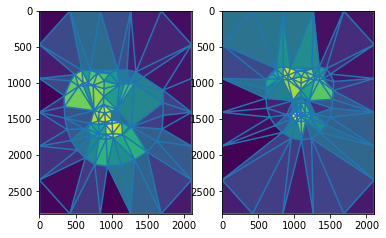

In [24]:
plt.subplot(1, 2, 1)
plt.imshow(seg1)
plt.triplot(landmark1[:,0], landmark1[:,1], simplices1)

plt.subplot(1, 2, 2)
plt.triplot(landmark2[:,0], landmark2[:,1], simplices2)
plt.imshow(seg2)
plt.show()

Change order

In [ ]:
matched_simplices = []
matched_tri2 = []
for simplex1 in simplices1:
    for simplex2 in simplices2:
        if set(simplex1) == set(simplex2):
            matched_simplices.append(simplex2)
            matched_tri2.append(landmark2[simplex2])
matched_simplices = np.array(matched_simplices)
matched_tri2 = np.array(matched_tri2)
print(matched_simplices.shape, simplices1.shape)

In [ ]:
plt.subplot(1, 2, 1)
plt.triplot(landmark1[:,0], landmark1[:,1], simplices1)
plt.imshow(image1)
plt.plot(landmark1[:,0], landmark1[:,1], 'o')
plt.subplot(1, 2, 2)
plt.triplot(landmark2[:,0], landmark2[:,1], matched_simplices)
plt.imshow(image2)
plt.plot(landmark2[:,0], landmark2[:,1], 'o')
plt.show()